Execute this cell below only when hosting code remotely.
This cell lets you import all code from https://github.com/maviddoerdijk/bsc-thesis/blob/main/src/.

Warning: when hosting remotely, none of the helper function code can be changed. Unless when you use specific branches.


In [4]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "helper-function-additions"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 168 (delta 85), reused 76 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (168/168), 4.91 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/bsc-thesis/src
backtesting/  data/       main.py  preprocessing/
config/       main.ipynb  models/  utils/


Now, let's start the notebook.

In [5]:
# Install missing Python packages in Google Colab
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets

In [48]:
# Import all packages
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import ta # technical indicators
import statsmodels.api as sm
import pywt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import math
from statsmodels.tsa.arima.model import ARIMA



# Custom helper functions
from data.data_collection import gather_data
from data.scraper import fetch_live_etf_tickers, load_cached_etf_tickers
from preprocessing.cointegration import find_cointegrated_pairs
from utils.visualization import plot_heatmap
from preprocessing.technical_indicators import add_technical_indicators, combine_pairs_data
from preprocessing.ols import add_OLS
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.wavelet_denoising import wav_den
from models.statistical_models import default_normalize, execute_kalman_workflow
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity

# Gather data

In [7]:
scrape_live = False
if scrape_live:
  instrumentIdsNASDAQandNYSE = fetch_live_etf_tickers()
else:
  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()

In [8]:
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
data = gather_data(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
data_close = data['close']
data_open = data['open']
data_high = data['high']
data_low = data['low']
data_vol = data['vol']

[*********************100%***********************]  777 of 777 completed
ERROR:yfinance:
523 Failed downloads:
ERROR:yfinance:['PATN', 'GXDW', 'DAPP', 'ECOW', 'IBGK', 'XAIX', 'CLOU', 'BSCW', 'SKYU', 'DWUS', 'NPFI', 'BUG', 'SEIS', 'HECO', 'SKRE', 'YOKE', 'ALIL', 'NSI', 'LITP', 'ESMV', 'PEPS', 'MYCK', 'QQQY', 'BTF', 'OOSB', 'QQQJ', 'PQJA', 'MRAL', 'TQQY', 'EKG', 'MSFU', 'WBND', 'FICS', 'APED', 'USSH', 'BSMW', 'BSMQ', 'GGLL', 'YSPY', 'BULD', 'OZEM', 'BSMP', 'QQQS', 'ASMG', 'IBTQ', 'BDGS', 'HYBI', 'MYMJ', 'UTHY', 'BSCY', 'BRTR', 'DYNI', 'SPCX', 'TEKX', 'PSWD', 'CA', 'BMAX', 'PANG', 'CONI', 'BAFE', 'SDTY', 'AVXC', 'PALU', 'CORO', 'BSCT', 'GQQQ', 'HERO', 'AVUQ', 'TPLS', 'UMMA', 'LGCF', 'NVDG', 'BUFM', 'SMCO', 'LIVR', 'TSMG', 'IBTO', 'CPLS', 'USAF', 'AVL', 'IBTF', 'MUD', 'TSLQ', 'LFSC', 'FTGS', 'RUNN', 'VPLS', 'SOLT', 'TEKY', 'ZTWO', 'MYCL', 'COWS', 'NFXS', 'LDEM', 'BKCH', 'FMTM', 'DVOL', 'INTW', 'XCNY', 'NIXT', 'UTEN', 'AMDG', 'AIRL', 'TCHI', 'QCLR', 'UTWO', 'BSJT', 'CANC', 'ICOP', 'SPAM', '

# Prepocessing
## Filtering ETFs: step 1. remove NaNs

In [9]:
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data_close, data_open, data_high, data_low, data_vol, data)

,IUSG,PKW,EMB,IFGL,FAD,FTCS,PIO,PUI,QCLN,TLT,...,GOVI,MBB,SHV,ICLN,IBB,RTH,USIG,SMH,PEZ,IMCV
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,19.410000,20.059999,92.000000,30.260000,23.709999,19.129999,16.110001,17.450001,19.040001,95.779999,...,27.080000,101.400002,110.309998,37.150002,26.913334,29.650000,44.505001,12.125000,19.080000,21.920000
2008-10-02,18.480000,19.340000,91.360001,28.980000,22.680000,18.200001,15.160000,16.790001,17.309999,96.550003,...,27.400000,102.190002,110.440002,33.910000,25.940001,28.600000,44.895000,11.550000,18.379999,21.020000
2008-10-03,18.219999,19.129999,91.180000,28.480000,22.320000,17.969999,14.830000,16.559999,16.889999,97.400002,...,27.459999,102.330002,110.320000,33.410000,25.633333,28.330000,45.080002,11.450000,18.139999,20.633333
2008-10-06,17.490000,18.400000,90.029999,26.330000,21.309999,17.139999,13.780000,15.670000,16.000000,99.169998,...,27.830000,101.440002,110.279999,29.809999,24.330000,27.366667,43.660000,11.220000,16.610001,19.866667
2008-10-07,16.565001,17.510000,88.209999,25.430000,20.719999,15.940000,12.460000,15.350000,13.870000,98.870003,...,27.760000,102.449997,110.360001,26.629999,23.373333,26.116667,44.634998,10.475000,16.770000,18.860001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,62.009998,61.209999,107.209999,29.040001,77.070000,55.330002,25.799999,28.299999,20.040001,116.680000,...,30.889999,103.019997,110.389999,8.620000,120.230003,110.660004,53.410000,53.075001,59.430000,54.476665
2018-09-26,61.750000,61.130001,107.699997,28.980000,76.629997,55.200001,25.910000,28.080000,19.910000,117.500000,...,31.070000,103.260002,110.410004,8.620000,120.610001,111.150002,53.669998,52.605000,59.990002,53.830002
2018-09-27,62.049999,61.110001,108.080002,28.850000,76.779999,55.209999,25.740000,28.350000,19.900000,117.580002,...,31.080000,103.269997,110.430000,8.610000,121.870003,111.400002,53.630001,52.935001,60.099998,53.873333


## Filtering ETFs: step 2. liquidity

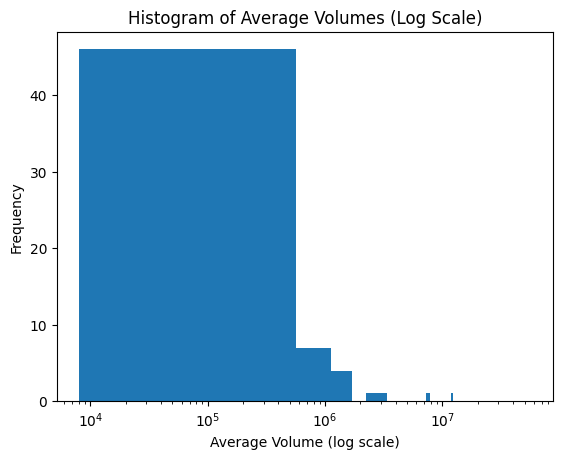

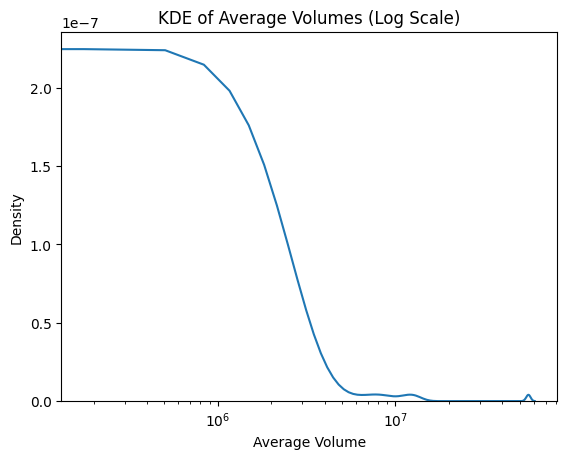

In [10]:
# data['yfinance_formatted'][['QQQ', 'IJJ']].xs('Volume', level='Price', axis=1)
min_vols = []
avg_vols = []
max_vols = []

for colnum in range(len(data_vol_filtered_1.columns)):
  # print(np.average(data_vol_filtered_1.iloc[:, colnum]))
  min_vols.append(np.min(data_vol_filtered_1.iloc[:, colnum]))
  avg_vols.append(np.average(data_vol_filtered_1.iloc[:, colnum]))
  max_vols.append(np.max(data_vol_filtered_1.iloc[:, colnum]))

plt.hist(avg_vols, bins=100)
plt.xscale('log')
plt.title("Histogram of Average Volumes (Log Scale)")
plt.xlabel("Average Volume (log scale)")
plt.ylabel("Frequency")
plt.show()

sns.kdeplot(avg_vols, bw_adjust=0.5)
plt.xscale('log')
plt.title("KDE of Average Volumes (Log Scale)")
plt.xlabel("Average Volume")
plt.show()

In [11]:
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

,IUSG,PKW,EMB,IFGL,TLT,ACWX,BBH,IGSB,IGIB,PPH,...,QQQ,PHO,IJT,PEY,MBB,SHV,IBB,RTH,USIG,SMH
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,19.410000,20.059999,92.000000,30.260000,95.779999,39.689999,60.250000,49.615002,46.009998,33.500000,...,38.500000,17.820000,30.100000,11.500000,101.400002,110.309998,26.913334,29.650000,44.505001,12.125000
2008-10-02,18.480000,19.340000,91.360001,28.980000,96.550003,37.720001,59.873333,49.959999,46.025002,33.060001,...,36.750000,16.410000,28.520000,11.160000,102.190002,110.440002,25.940001,28.600000,44.895000,11.550000
2008-10-03,18.219999,19.129999,91.180000,28.480000,97.400002,37.389999,60.266666,49.630001,45.700001,32.849998,...,36.180000,16.120001,27.775000,10.830000,102.330002,110.320000,25.633333,28.330000,45.080002,11.450000
2008-10-06,17.490000,18.400000,90.029999,26.330000,99.169998,35.020000,56.266666,48.419998,45.724998,31.655001,...,34.860001,15.000000,26.965000,10.460000,101.440002,110.279999,24.330000,27.366667,43.660000,11.220000
2008-10-07,16.565001,17.510000,88.209999,25.430000,98.870003,33.189999,54.033333,48.669998,45.735001,30.424999,...,32.650002,14.360000,25.395000,9.470000,102.449997,110.360001,23.373333,26.116667,44.634998,10.475000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,62.009998,61.209999,107.209999,29.040001,116.680000,48.080002,133.539993,51.759998,52.889999,64.059998,...,184.139999,31.920000,101.599998,17.950001,103.019997,110.389999,120.230003,110.660004,53.410000,53.075001
2018-09-26,61.750000,61.130001,107.699997,28.980000,117.500000,48.090000,134.529999,51.810001,53.049999,63.939999,...,184.270004,31.760000,100.459999,17.820000,103.260002,110.410004,120.610001,111.150002,53.669998,52.605000
2018-09-27,62.049999,61.110001,108.080002,28.850000,117.580002,48.070000,135.860001,51.820000,53.090000,64.260002,...,185.830002,31.709999,100.599998,17.860001,103.269997,110.430000,121.870003,111.400002,53.630001,52.935001


# Find Co-Integrated Pairs

First, let's try to estimate the time we need.

In [12]:
import time
n_test_pairs = 10
start_time = time.time()
first_n_test_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_test_pairs]
scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2[first_n_test_cols])
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
seconds_per_pair = (end_time - start_time) / n_test_pairs
print(f"Seconds per pair: {seconds_per_pair:.2f}")

Completed 45 pairs
Execution time: 17.72 seconds
Seconds per pair: 1.77


In [13]:
from enum import unique


n_cols = len(data_original_format_filtered_2.columns.get_level_values('Ticker').unique())
max_cols = 30
if n_cols > max_cols and max_cols > 0:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:max_cols]
    n_cols = max_cols
else:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()
first_n_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_cols]
# combinatorially find number of unique pairs of columns
unique_pairs = n_cols * (n_cols - 1) / 2
expected_time = unique_pairs * seconds_per_pair
print(f"Expected time to run all pairs: {expected_time / 60:.2f} minutes")

Expected time to run all pairs: 12.84 minutes


In [14]:
# First, we'll try it for a smaller (random) subset of the data
start_time = time.time()
scores, pvalues, pairs = find_cointegrated_pairs(data['yfinance_formatted'][first_n_cols])
# TODO: remove all perfectly cointegrated  variables where the error code shown below is given:
# /content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case. \ result = coint(S1, S2)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
pairs_data_filtered

Completed 435 pairs
Execution time: 65.86 seconds


[(('EMB', 'SHY'), np.float64(2.3472860911249982e-05)),
 (('IGSB', 'SHY'), np.float64(0.00011659037067869815)),
 (('IGSB', 'PID'), np.float64(0.00013065834446531683)),
 (('EMB', 'BBH'), np.float64(0.00016368052941495635)),
 (('EMB', 'PPH'), np.float64(0.0005865778780813238)),
 (('IFGL', 'IGSB'), np.float64(0.0007860628026761384)),
 (('EMB', 'TLT'), np.float64(0.0008242071808442096)),
 (('EMB', 'SOXX'), np.float64(0.0009406742680257004)),
 (('EMB', 'IUSV'), np.float64(0.0009412070917321167)),
 (('IGIB', 'SOXX'), np.float64(0.0011449063816258193)),
 (('IGSB', 'TUR'), np.float64(0.0012000464207276634)),
 (('IGSB', 'PPH'), np.float64(0.0013347040611567185)),
 (('IGSB', 'IEI'), np.float64(0.0014210377492403314)),
 (('IGSB', 'DVY'), np.float64(0.0014398881633678113)),
 (('EMB', 'ONEQ'), np.float64(0.0014626855085388638)),
 (('EMB', 'QTEC'), np.float64(0.0016077806507624345)),
 (('EMB', 'PNQI'), np.float64(0.0016326990239281208)),
 (('EMB', 'FEX'), np.float64(0.0018163565563794237)),
 (('IGSB'

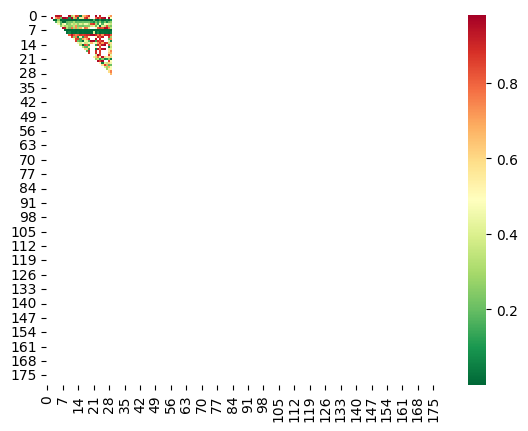

In [15]:
from utils.visualization import plot_heatmap
plot_heatmap(pvalues)

Most highly cointegrated pair: EMB and SHY


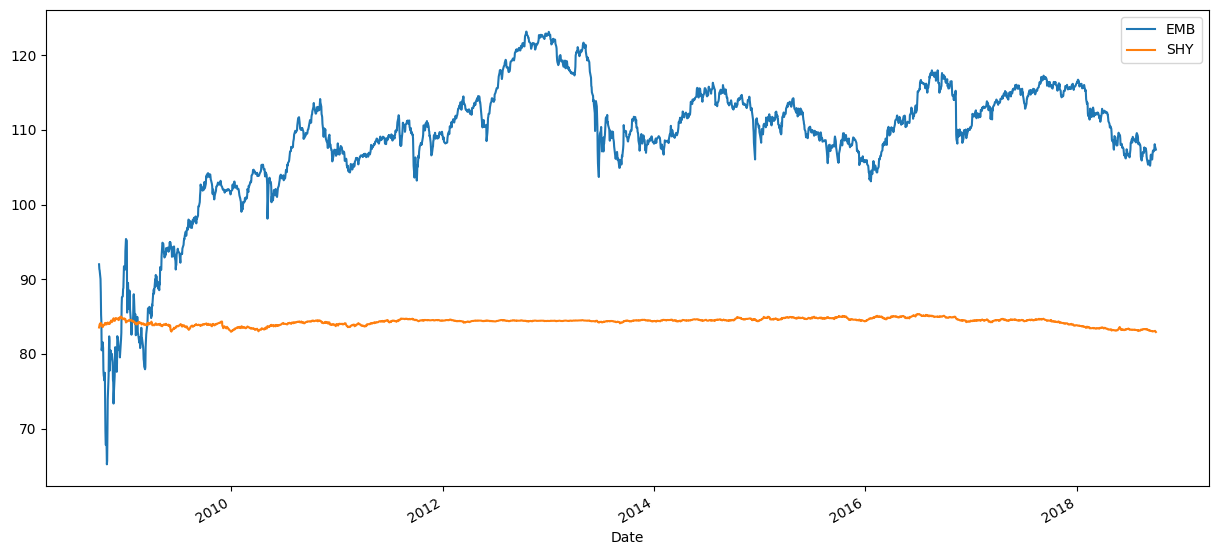

In [16]:
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
# ticker_a, ticker_b = "IGHB", "SHY"
print(f"Most highly cointegrated pair: {ticker_a} and {ticker_b}")

pairs_timeseries = ({'S1_close':data_close_filtered_2[ticker_a],'S2_close':data_close_filtered_2[ticker_b]
                         ,'S1_open':data_open_filtered_2[ticker_a],'S2_open':data_open_filtered_2[ticker_b]
                         ,'S1_high':data_high_filtered_2[ticker_a],'S2_high':data_high_filtered_2[ticker_b]
                         ,'S1_low':data_low_filtered_2[ticker_a],'S2_low':data_low_filtered_2[ticker_b]
                         ,'S1_volume':data_vol_filtered_2[ticker_a],'S2_volume':data_vol_filtered_2[ticker_b]})
pairs_timeseries['S1_close'].plot(figsize=(15,7))
pairs_timeseries['S2_close'].plot(figsize=(15,7))
plt.legend([ticker_a, ticker_b])


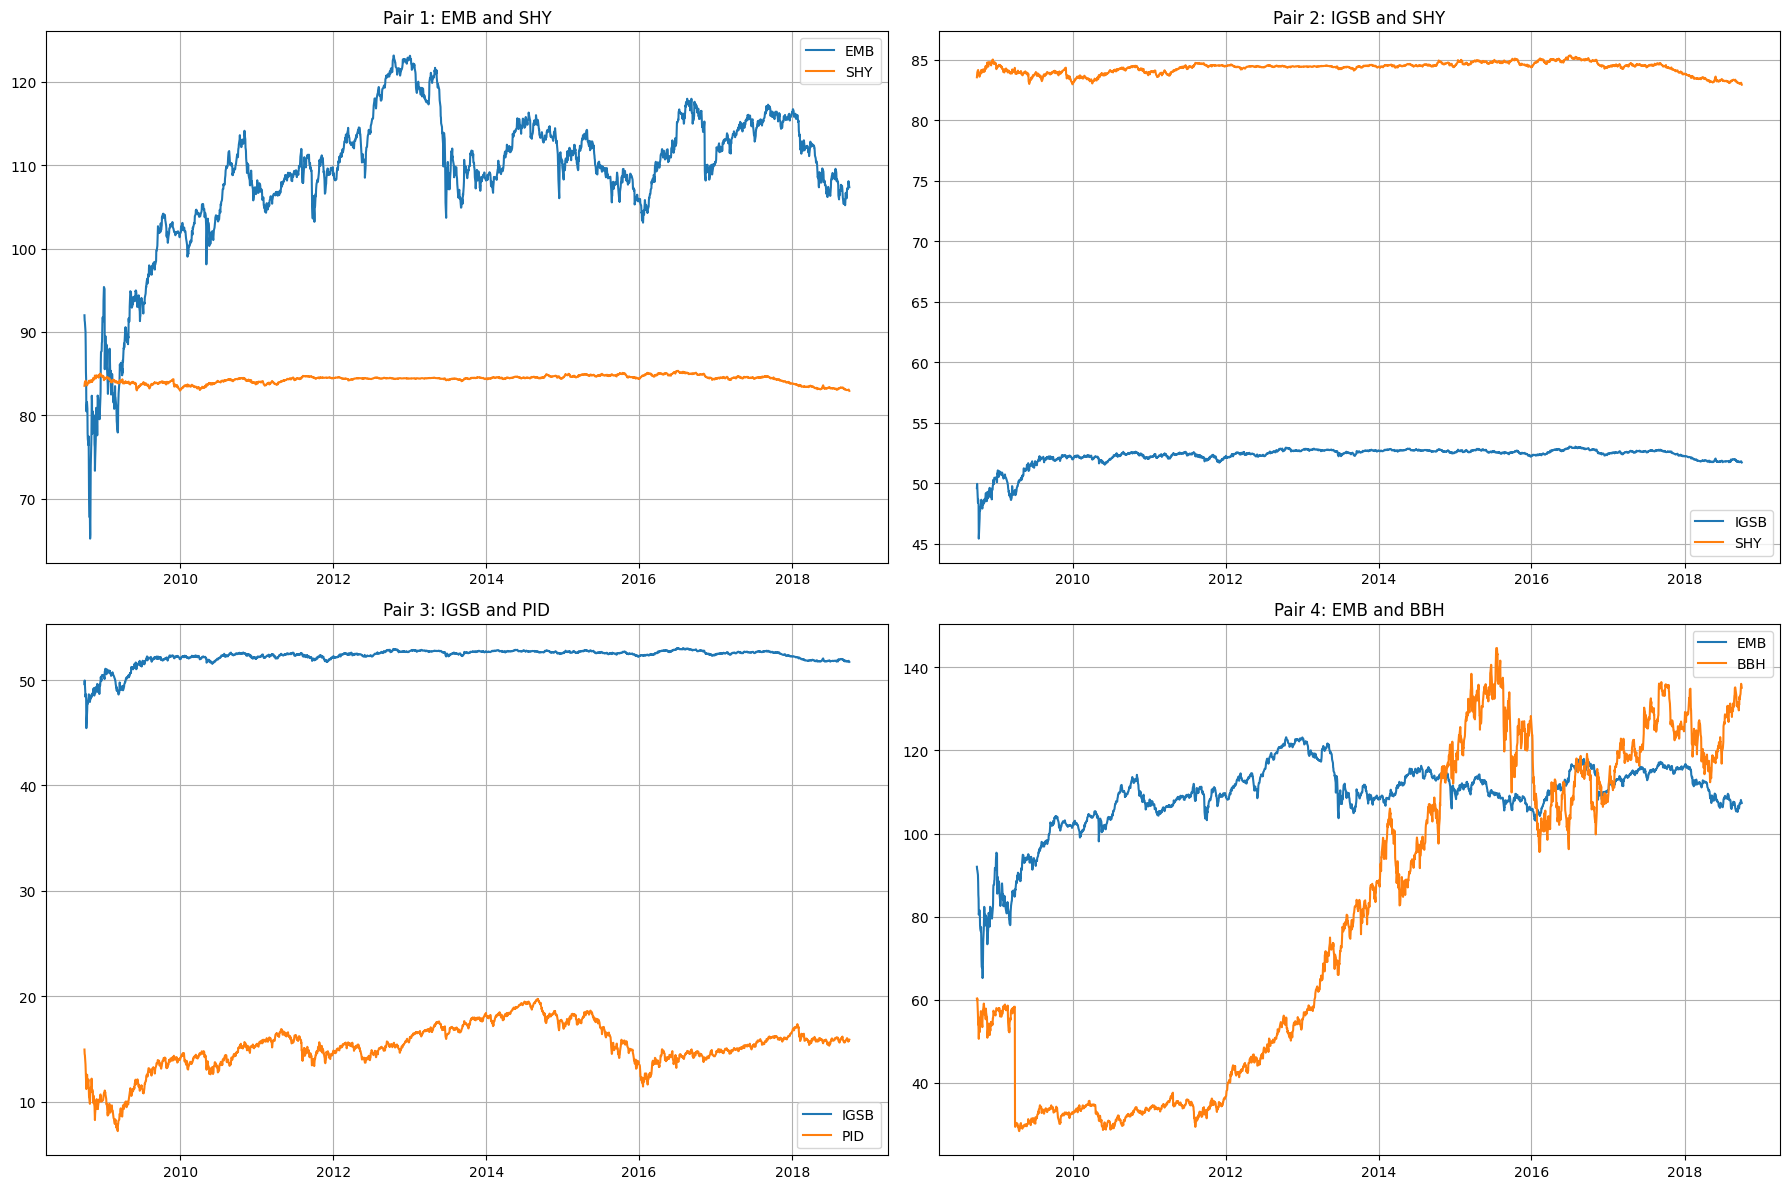

In [17]:
# Now Plot a grid of top 4 pairs
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

for i in range(4):
    ticker_a_temp, ticker_b_temp = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]

    s1_close = data_close_filtered_2[ticker_a_temp]
    s2_close = data_close_filtered_2[ticker_b_temp]

    axs[i].plot(s1_close, label=ticker_a_temp)
    axs[i].plot(s2_close, label=ticker_b_temp)
    axs[i].set_title(f'Pair {i+1}: {ticker_a_temp} and {ticker_b_temp}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Training: Kalman Filters

Now, it's time for training.

Step 1: Adding Technical Indicators

In [18]:
pairs_timeseries_including_ta = add_technical_indicators(pairs_timeseries)
pairs_timeseries_final = add_OLS(pairs_timeseries_including_ta)

/content/bsc-thesis/src/preprocessing/ols.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = -est.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_op = -est_op.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hi = -est_hi.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:20: FutureWarning: Series.

Now, let's take a look at the (hopefully) mean-reverting spread.

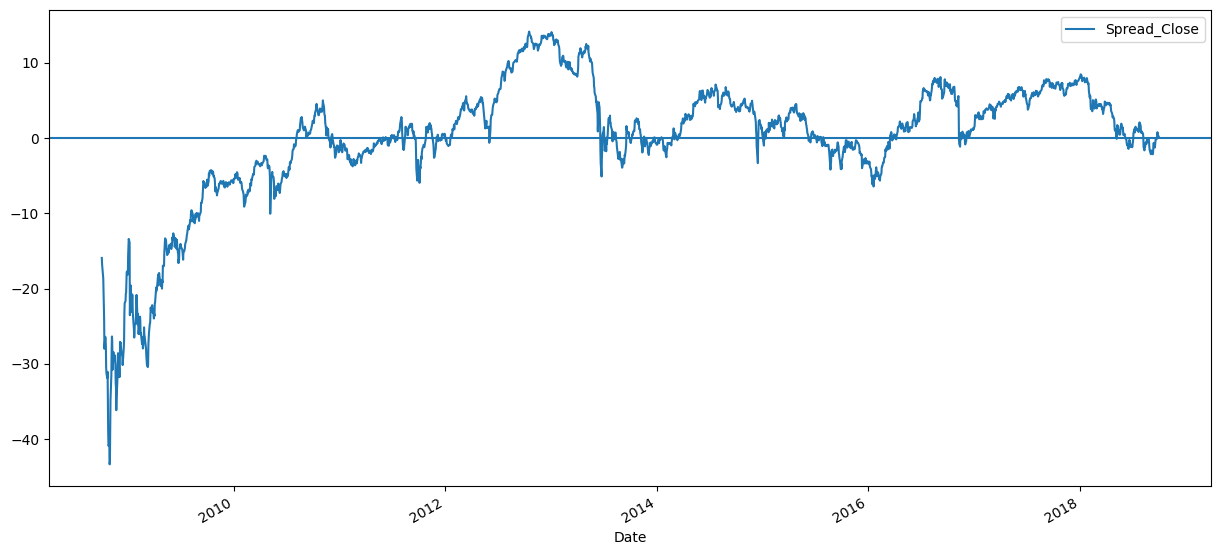

In [19]:
pairs_timeseries_final['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pairs_timeseries_final['Spread_Close'].mean())
plt.legend(['Spread_Close'])

## Wavelet Denoising
Now, we apply simple wavelet denoising

In [20]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
                                          'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
                                           'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
                                           'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pairs_timeseries = pd.DataFrame({'Spread_Close':pairs_timeseries_final['Spread_Close'][30:],
                               'Spread_Open':pairs_timeseries_final['Spread_Open'][30:],
                               'Spread_High':pairs_timeseries_final['Spread_High'][30:],
                               'Spread_Low':pairs_timeseries_final['Spread_Low'][30:],
                               'S1_volume':pairs_timeseries_final['S1_volume'][30:],
                               'S2_volume':pairs_timeseries_final['S2_volume'][30:],
                               'S1_rsi':pairs_timeseries_final['S1_rsi'][30:],
                               'S2_rsi':pairs_timeseries_final['S2_rsi'][30:],
                               'S1_mfi':pairs_timeseries_final['S1_mfi'][30:],
                               'S2_mfi':pairs_timeseries_final['S2_mfi'][30:],
                               'S1_adi':pairs_timeseries_final['S1_adi'][30:],
                               'S2_adi':pairs_timeseries_final['S2_adi'][30:],
                               'S1_vpt':pairs_timeseries_final['S1_vpt'][30:],
                               'S2_vpt':pairs_timeseries_final['S2_vpt'][30:],
                               'S1_atr':pairs_timeseries_final['S1_atr'][30:],
                               'S2_atr':pairs_timeseries_final['S2_atr'][30:],
                               'S1_bb_ma':pairs_timeseries_final['S1_bb_ma'][30:],
                               'S2_bb_ma':pairs_timeseries_final['S2_bb_ma'][30:],
                               'S1_adx':pairs_timeseries_final['S1_adx'][30:],
                               'S2_adx':pairs_timeseries_final['S2_adx'][30:],
                               'S1_ema':pairs_timeseries_final['S1_ema'][30:],
                               'S2_ema':pairs_timeseries_final['S2_ema'][30:],
                               'S1_macd':pairs_timeseries_final['S1_macd'][30:],
                               'S2_macd':pairs_timeseries_final['S2_macd'][30:],
                               'S1_dlr':pairs_timeseries_final['S1_dlr'][30:],
                               'S2_dlr':pairs_timeseries_final['S2_dlr'][30:]
                              }, columns = cols)

In [21]:
train_size = int(len(lstm_pairs_timeseries) * 0.9)
dev_size = int((len(lstm_pairs_timeseries) - train_size) * 0.5) - 30
test_size = len(lstm_pairs_timeseries) - train_size - dev_size
train, dev, test = lstm_pairs_timeseries[0:train_size], lstm_pairs_timeseries[train_size:train_size + dev_size], lstm_pairs_timeseries[train_size + dev_size:len(lstm_pairs_timeseries)]
print(len(train), len(dev), len(test))

2239 94 155


In [22]:
# first test whether wavelet denoising is working as expected
debug_train_den = pd.DataFrame(columns = cols)
col = cols[0]
train[col]

,Spread_Close
Date,
2008-11-12,-29.304724
2008-11-13,-29.563403
2008-11-14,-28.837563
2008-11-17,-30.141360
2008-11-18,-32.637636
...,...
2017-09-28,6.908203
2017-09-29,7.314045
2017-10-02,6.766960


In [23]:
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

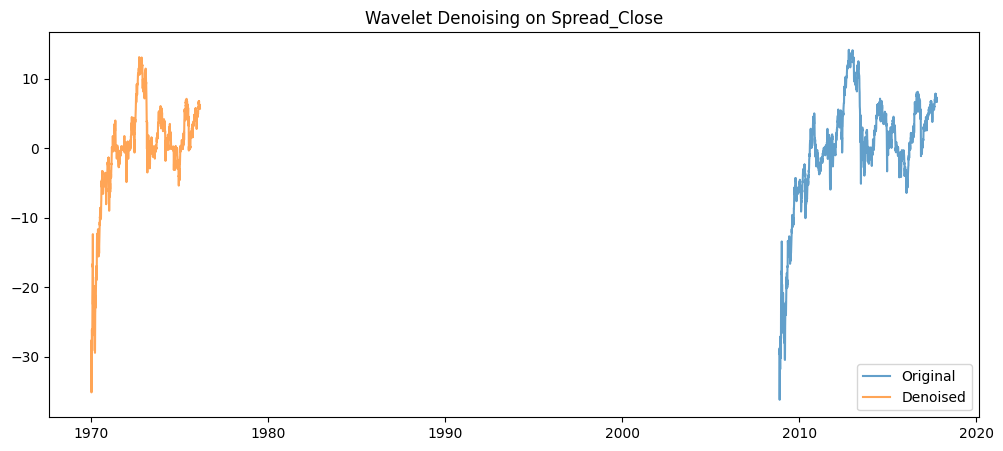

Original mean: 0.0003873188377390594
Denoised mean: -0.14213138317155066
Original head: Date
2008-11-12   -29.304724
2008-11-13   -29.563403
2008-11-14   -28.837563
2008-11-17   -30.141360
2008-11-18   -32.637636
2008-11-19   -33.122669
2008-11-20   -36.169381
2008-11-21   -34.688505
2008-11-24   -31.997196
2008-11-25   -29.227632
Name: Spread_Close, dtype: float64
Denoised head: [-28.50620897 -27.82016412 -29.10947918 -31.59143775 -32.11564199
 -35.10320931 -33.68219826 -30.94851182 -28.20694851 -27.55202924]


In [24]:
# Possible columns:
# ['Spread_Close',
#  'Spread_Open',
#  'Spread_High',
#  'Spread_Low',
#  'S1_volume',
#  'S2_volume',
#  'S1_rsi',
#  'S2_rsi',
#  'S1_mfi',
#  'S2_mfi',
#  'S1_adi',
#  'S2_adi',
#  'S1_vpt',
#  'S2_vpt',
#  'S1_atr',
#  'S2_atr',
#  'S1_bb_ma',
#  'S2_bb_ma',
#  'S1_adx',
#  'S2_adx',
#  'S1_ema',
#  'S2_ema',
#  'S1_macd',
#  'S2_macd',
#  'S1_dlr',
#  'S2_dlr']
col = 'Spread_Close'
original = train[col]
denoised = wav_den(original)

plt.figure(figsize=(12, 5))
plt.plot(original, label='Original', alpha=0.7)
plt.plot(denoised, label='Denoised', alpha=0.7)
plt.legend()
plt.title(f'Wavelet Denoising on {col}')
plt.show()

print(f'Original mean: {original.mean()}')
print(f'Denoised mean: {denoised.mean()}')
print(f'Original head: {original[:10]}')
print(f'Denoised head: {denoised[:10]}')

<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 1.60979


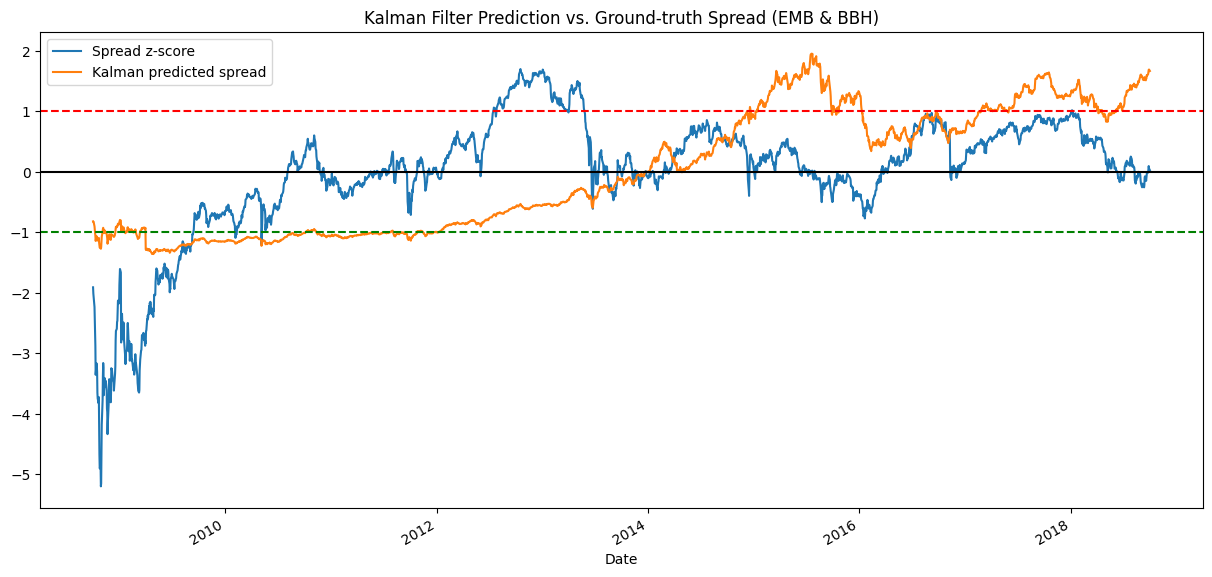

In [33]:
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

out_kalman = execute_kalman_workflow(
    pairs_timeseries_df,
    train_frac=0.8,              # ← change whatever you like
    dev_frac=0.1,
    look_back=1,
    verbose=True
)

print(f"MSE on test: {out_kalman['mse']:.5f}")

plt.figure(figsize=(15, 7))
default_normalize(pairs_timeseries_final['Spread_Close']).plot(label='Spread z-score')
out_kalman['kalman_result'].plot(label='Kalman predicted spread')
plt.axhline(0, color='black')
plt.axhline( 1, color='red',   ls='--')
plt.axhline(-1, color='green', ls='--')
plt.legend()
plt.title(f"Kalman Filter Prediction vs. Ground-truth Spread ({ticker_a} & {ticker_b})")
plt.show()

Now, let's try it out for the top 10 best cointegrated tickers

<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 0.42962


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 1.41876
Split sizes — train: 1990, dev: 248, test: 250


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

MSE on test: 0.82900
Split sizes — train: 1990, dev: 248, test: 250


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

MSE on test: 1.60979


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 1.16128


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 1.17942


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 1.02075


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

Split sizes — train: 1990, dev: 248, test: 250
MSE on test: 2.08734
Split sizes — train: 1990, dev: 248, test: 250


<ipython-input-33-00b4fb2ab4b3>:255: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
<ipython-input-33-00b4fb2ab4b3>:257: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_h = -sm.OLS(df['S1_high'], df['S2_high']).fit().par

MSE on test: 1.44412


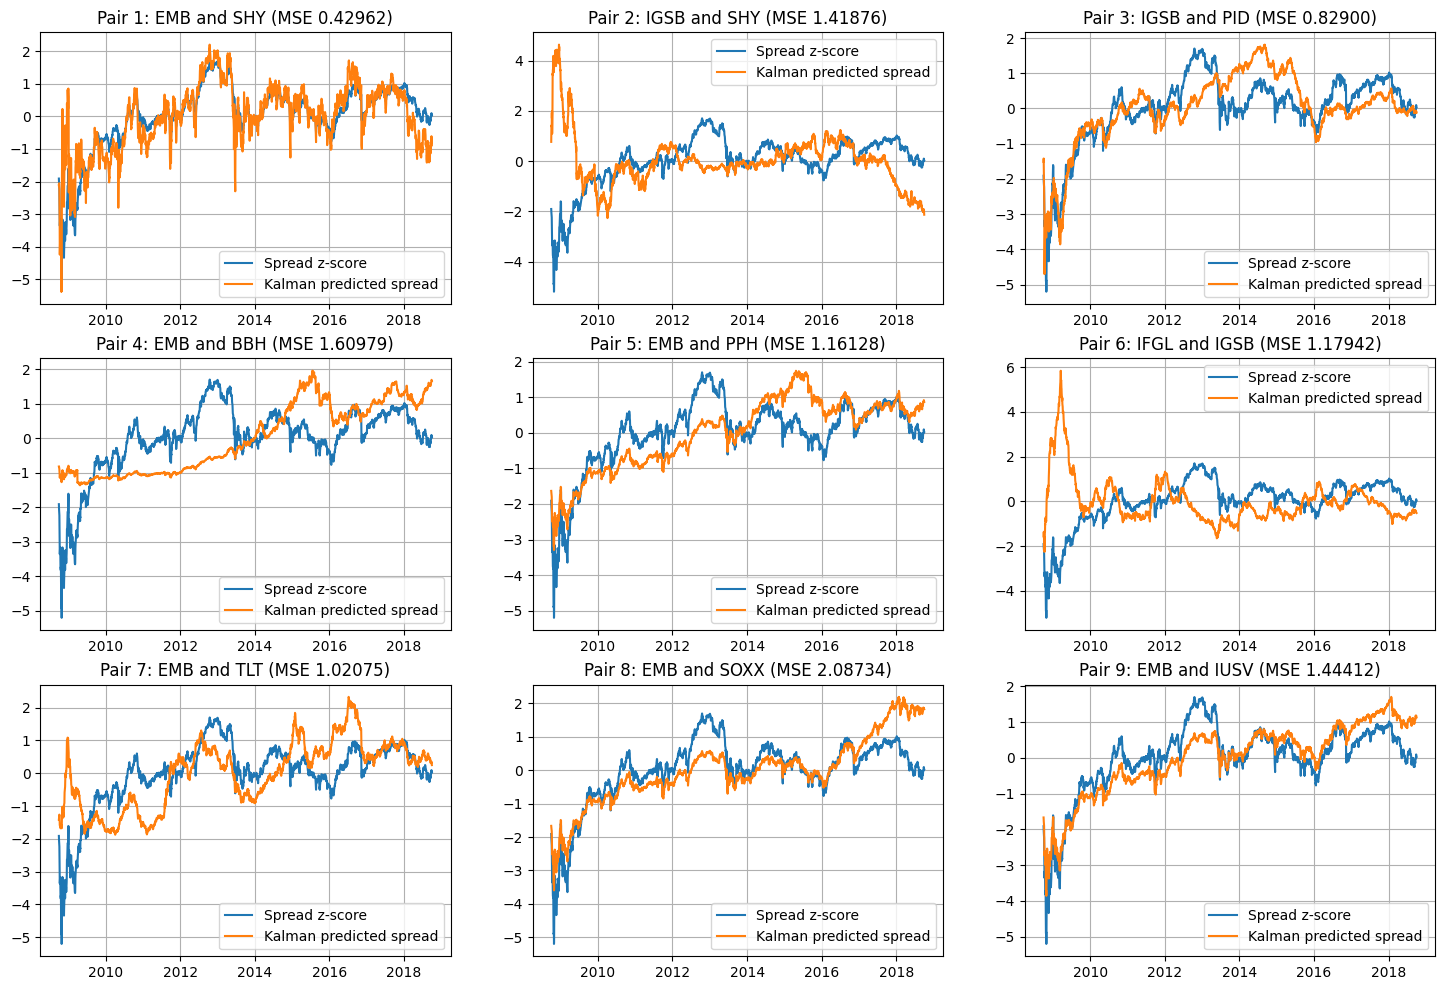

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i in range(9):
    ticker_a_temp, ticker_b_temp = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a_temp, ticker_b_temp)

    out_kalman = execute_kalman_workflow(
        pairs_timeseries_df,
        train_frac=0.8,              # ← change whatever you like
        dev_frac=0.1,
        look_back=1,
        verbose=True
    )
    print(f"MSE on test: {out_kalman['mse']:.5f}")
    axs[i].plot(default_normalize(pairs_timeseries_final['Spread_Close']), label='Spread z-score')
    axs[i].plot(out_kalman['kalman_result'], label='Kalman predicted spread')
    axs[i].set_title(f"Pair {i+1}: {ticker_a_temp} and {ticker_b_temp} (MSE {out_kalman['mse']:.5f})")
    axs[i].legend()
    axs[i].grid(True)



# Training: Time-series Transformer
Now, let's look at a Transformer.

In the future, this code will be completely hosted in modules rather than the notebook, but for now we will try things out in the notebook.

154


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


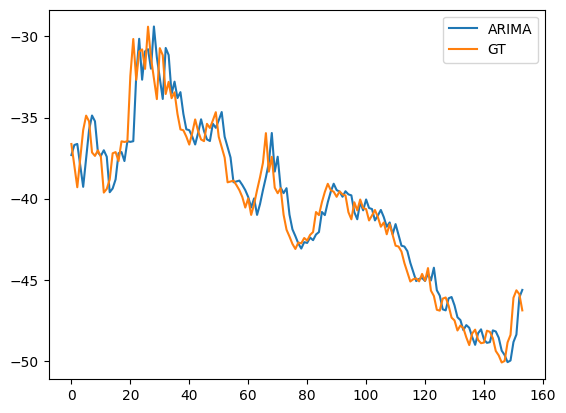

In [42]:
from statsmodels.tsa.arima.model import ARIMA

look_back = 1
# First, try a simpler ARIMA model

# use pairs_timeseries_df
# for ML tasks, we must limit the timeseries to not use the first 30 elements, because technical indicators require a lookback window.
# With this lookback window, the first x (in this case x=30) values of the indicators are NaN.
# Seeing as the ML tasks actually use the technical indicators, we must remove the first 30 values
pairs_timeseries_df_limited_ml = pd.DataFrame({'Spread_Close':pairs_timeseries_df['Spread_Close'][30:],
                                              'Spread_Open':pairs_timeseries_df['Spread_Open'][30:],
                                              'Spread_High':pairs_timeseries_df['Spread_High'][30:],
                                              'Spread_Low':pairs_timeseries_df['Spread_Low'][30:],
                                              'S1_volume':pairs_timeseries_df['S1_volume'][30:],
                                              'S2_volume':pairs_timeseries_df['S2_volume'][30:],
                                              'S1_rsi':pairs_timeseries_df['S1_rsi'][30:],
                                              'S2_rsi':pairs_timeseries_df['S2_rsi'][30:],
                                              'S1_mfi':pairs_timeseries_df['S1_mfi'][30:],
                                              'S2_mfi':pairs_timeseries_df['S2_mfi'][30:],
                                              'S1_adi':pairs_timeseries_df['S1_adi'][30:],
                                              'S2_adi':pairs_timeseries_df['S2_adi'][30:],
                                              'S1_vpt':pairs_timeseries_df['S1_vpt'][30:],
                                              'S2_vpt':pairs_timeseries_df['S2_vpt'][30:],
                                              'S1_atr':pairs_timeseries_df['S1_atr'][30:],
                                              'S2_atr':pairs_timeseries_df['S2_atr'][30:],
                                              'S1_bb_ma':pairs_timeseries_df['S1_bb_ma'][30:],
                                              'S2_bb_ma':pairs_timeseries_df['S2_bb_ma'][30:],
                                              'S1_adx':pairs_timeseries_df['S1_adx'][30:],
                                              'S2_adx':pairs_timeseries_df['S2_adx'][30:],
                                              'S1_ema':pairs_timeseries_df['S1_ema'][30:],
                                              'S2_ema':pairs_timeseries_df['S2_ema'][30:],
                                              'S1_macd':pairs_timeseries_df['S1_macd'][30:],
                                              'S2_macd':pairs_timeseries_df['S2_macd'][30:],
                                              'S1_dlr':pairs_timeseries_df['S1_dlr'][30:],
                                              'S2_dlr':pairs_timeseries_df['S2_dlr'][30:]
                                              }, columns = cols)


scaler = MinMaxScaler(feature_range=(0, 1))


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))


testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

yhat_ARIMA = []
yhat_ARIMA_mse = []
data = pairs_timeseries_df_limited_ml['Spread_Close'].values
for i in range(train_size+dev_size, len(pairs_timeseries_df_limited_ml)-1):
    model = ARIMA(data[:i], order=(1,0,0))
    model_fit = model.fit()
    forecast = (model_fit.forecast(steps=look_back))
    yhat_ARIMA.append(forecast[0])
    yhat_ARIMA_mse.append(np.array(forecast))
mse = 0.0
mse = acc_metric(testY_untr, yhat_ARIMA_mse) # np.float64(0.6146036096722168) - pretty good score.
plt.plot(yhat_ARIMA, label='ARIMA')
# plot actual timeseries
groundtruth_values = pairs_timeseries_df_limited_ml['Spread_Close'].values[train_size + dev_size + 1 : len(pairs_timeseries_df_limited_ml)]
plt.plot(groundtruth_values, label='GT')
plt.legend()
plt.show()

Now, put that code into an `execute_workflow` function: